# **Importing Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras import layers, models, optimizers, Input
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Constants**

In [2]:
# Constants
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
NUM_CLASSES=26
SEED = 42
EPOCHS = 15 # Adjusted for quick demonstration
N_SPLITS = 8  # Number of folds for K-fold cross-validation

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# **image path & data frames**

In [3]:
# Define the correct path to the dataset directory
IMAGE_PATH = Path("/kaggle/input/american-hand-sign-detection/Data")

# Check if the directory exists
if not IMAGE_PATH.is_dir():
    raise FileNotFoundError(f"Directory not found: {IMAGE_PATH}")

# Check image paths and labels
total_images = list(IMAGE_PATH.rglob("*.jpg"))
print(f"Total Images = {len(total_images)}")

# Initialize lists for image paths and labels
images_path = []
labels = []

# Iterate over each image path
for image_path in total_images:
    parent_dir = image_path.parent
    if parent_dir.stem:  # Ensure the parent directory has a name
        images_path.append(image_path)
        labels.append(parent_dir.stem)  # Label is the parent directory's name

# Create DataFrame
df_path_and_label = pd.DataFrame({'path': images_path, 'label': labels})

# Check if DataFrame is not empty
if len(df_path_and_label) > 0:
    # Split dataset
    df_train, df_rest = tts(df_path_and_label, test_size=0.3, random_state=123, stratify=df_path_and_label["label"])
    df_val, df_test = tts(df_rest, test_size=0.5, random_state=123, stratify=df_rest["label"])

    classes = sorted(df_path_and_label["label"].unique())
    label_map = dict(zip(classes, range(len(classes))))
else:
    raise ValueError("The dataset is empty. Check the paths and image loading process.")

# Convert the 'path' column to string
df_train['path'] = df_train['path'].astype(str)
df_val['path'] = df_val['path'].astype(str)
df_test['path'] = df_test['path'].astype(str)
data_df = df_train

Total Images = 8066


# **Data Augmentation**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

def dataframe_to_generator(df, datagen, label_map, img_size, batch_size, shuffle=True):
    return datagen.flow_from_dataframe(
        df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',  # One-hot encoding of labels
        batch_size=batch_size,
        shuffle=shuffle,
        classes=label_map  # Optional, but helps if explicit label mapping is needed
    )

# Assuming IMG_SIZE = (height, width) and BATCH_SIZE is defined
train_generator = dataframe_to_generator(df_train, train_datagen, label_map, IMG_SIZE, BATCH_SIZE)
valid_generator = dataframe_to_generator(df_val, valid_test_datagen, label_map, IMG_SIZE, BATCH_SIZE)
test_generator = dataframe_to_generator(df_test, valid_test_datagen, label_map, IMG_SIZE, BATCH_SIZE, shuffle=False)


Found 5646 validated image filenames belonging to 26 classes.
Found 1210 validated image filenames belonging to 26 classes.
Found 1210 validated image filenames belonging to 26 classes.


# **Deep Convolutional Neural Network**

In [5]:
from tensorflow.keras import regularizers, callbacks

def make_stage(x, filters_in, filters_out, stride, dropout_rate=0.3, l2_rate=1e-4):
    x = layers.Conv2D(filters_in, kernel_size=3, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_rate))(x)  # L2 Regularization
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters_out, kernel_size=3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_rate))(x)  # L2 Regularization
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dropout(dropout_rate)(x)  # Adding Dropout to prevent overfitting
    
    return x


def CNN_model(input_shape, num_classes, dropout_rate=0.3, l2_rate=1e-4):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', 
                      kernel_regularizer=regularizers.l2(l2_rate))(inputs)  # L2 Regularization
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = make_stage(x, 64, 128, stride=2, dropout_rate=dropout_rate, l2_rate=l2_rate)
    x = make_stage(x, 128, 256, stride=2, dropout_rate=dropout_rate, l2_rate=l2_rate)
    x = make_stage(x, 256, 512, stride=2, dropout_rate=dropout_rate, l2_rate=l2_rate)
    x = make_stage(x, 512, 1024, stride=2, dropout_rate=dropout_rate, l2_rate=l2_rate)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    # Optional additional dropout before the dense layer
    x = layers.Dropout(0.5)(x)  # Dropping 50% of neurons in the fully connected layer
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    return model

# Define input shape properly by unpacking IMG_SIZE
input_shape = (*IMG_SIZE, 3)  # Unpack IMG_SIZE to define height and width
num_classes = len(classes)

# Instantiate the model
model = CNN_model(input_shape, num_classes, dropout_rate=0.3, l2_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early stopping callback to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 2, 2, 256)      │             

 Total params: 9,451,098 (36.05 MB)

 Trainable params: 9,445,210 (36.03 MB)

 Non-trainable params: 5,888 (23.00 KB)

# **Training and Validation**

In [6]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

all_y_true = []
all_y_pred = []

for fold, (train_index, val_index) in enumerate(skf.split(data_df, data_df['label']), 1):
    print(f'Fold {fold}/{N_SPLITS}')

    train_df = data_df.iloc[train_index].reset_index(drop=True)
    val_df = data_df.iloc[val_index].reset_index(drop=True)

    train_loader = tf.data.Dataset.from_tensor_slices((
        train_df['path'].values,
        tf.cast(to_categorical(train_df['label'].apply(lambda x: label_map[x]).values, num_classes=len(classes)), tf.int32)
    ))

    def preprocess_frame_sequence(x, y, training=False):
        # Load image from path x
        image = tf.io.read_file(x)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

        if training:  # Apply transformations only during training
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        return image, y

    # Update the call to `map` to include the `training` argument
    train_dataset = (train_loader
                     .map(lambda x, y: preprocess_frame_sequence(x, y, training=True), num_parallel_calls=AUTO)
                     .shuffle(len(train_df))  # Shuffle buffer size
                     .batch(BATCH_SIZE)
                     .prefetch(AUTO))

    val_loader = tf.data.Dataset.from_tensor_slices((
        val_df['path'].values,
        tf.cast(to_categorical(val_df['label'].apply(lambda x: label_map[x]).values, num_classes=len(classes)), tf.int32)
    ))
    val_dataset = (val_loader
                   .map(lambda x, y: preprocess_frame_sequence(x, y, training=False), num_parallel_calls=AUTO)
                   .batch(BATCH_SIZE)
                   .prefetch(AUTO))

    # Model creation and compilation
    model = CNN_model(input_shape, num_classes)  # Update model to handle frame sequences if necessary

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early Stopping and Model Checkpoint
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f'best_model_fold{fold}.keras', save_best_only=True, monitor='val_loss')
    ]

    # Training the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)
    np.save(f'fold{fold}_history.npy', history.history)

    y_true_fold = []
    y_pred_fold = []

    for images, labels in val_dataset:
        predictions = model.predict(images, verbose=0)
        y_true_fold.extend(np.argmax(labels.numpy(), axis=1))
        y_pred_fold.extend(np.argmax(predictions, axis=1))

    all_y_true.extend(y_true_fold)
    all_y_pred.extend(y_pred_fold)

# Save the true and predicted labels
np.save('all_y_true.npy', all_y_true)
np.save('all_y_pred.npy', all_y_pred)


Fold 1/8
Epoch 1/15


I0000 00:00:1731097196.686793     100 service.cc:145] XLA service 0x7cf7e4005b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731097196.686858     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 10/155 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0578 - loss: 4.5727

I0000 00:00:1731097212.920177     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.1219 - loss: 3.8262 - val_accuracy: 0.0397 - val_loss: 3.4440
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6791 - loss: 1.1595 - val_accuracy: 0.1445 - val_loss: 3.3878
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9094 - loss: 0.4325 - val_accuracy: 0.9122 - val_loss: 0.5040
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9721 - loss: 0.2492 - val_accuracy: 0.9986 - val_loss: 0.1462
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9806 - loss: 0.2108 - val_accuracy: 0.9986 - val_loss: 0.1411
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9872 - loss: 0.1850 - val_accuracy: 0.9986 - val_loss: 0.1391
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9929 - loss: 0.1663 - val_accuracy: 0.9986 - val_loss: 0.1381
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9943 - loss: 0.1615 - val_accuracy: 0.9

In [7]:
model.save(f'model_fold{6}.h5')

# **Validation Accuracy & Loss**

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
177

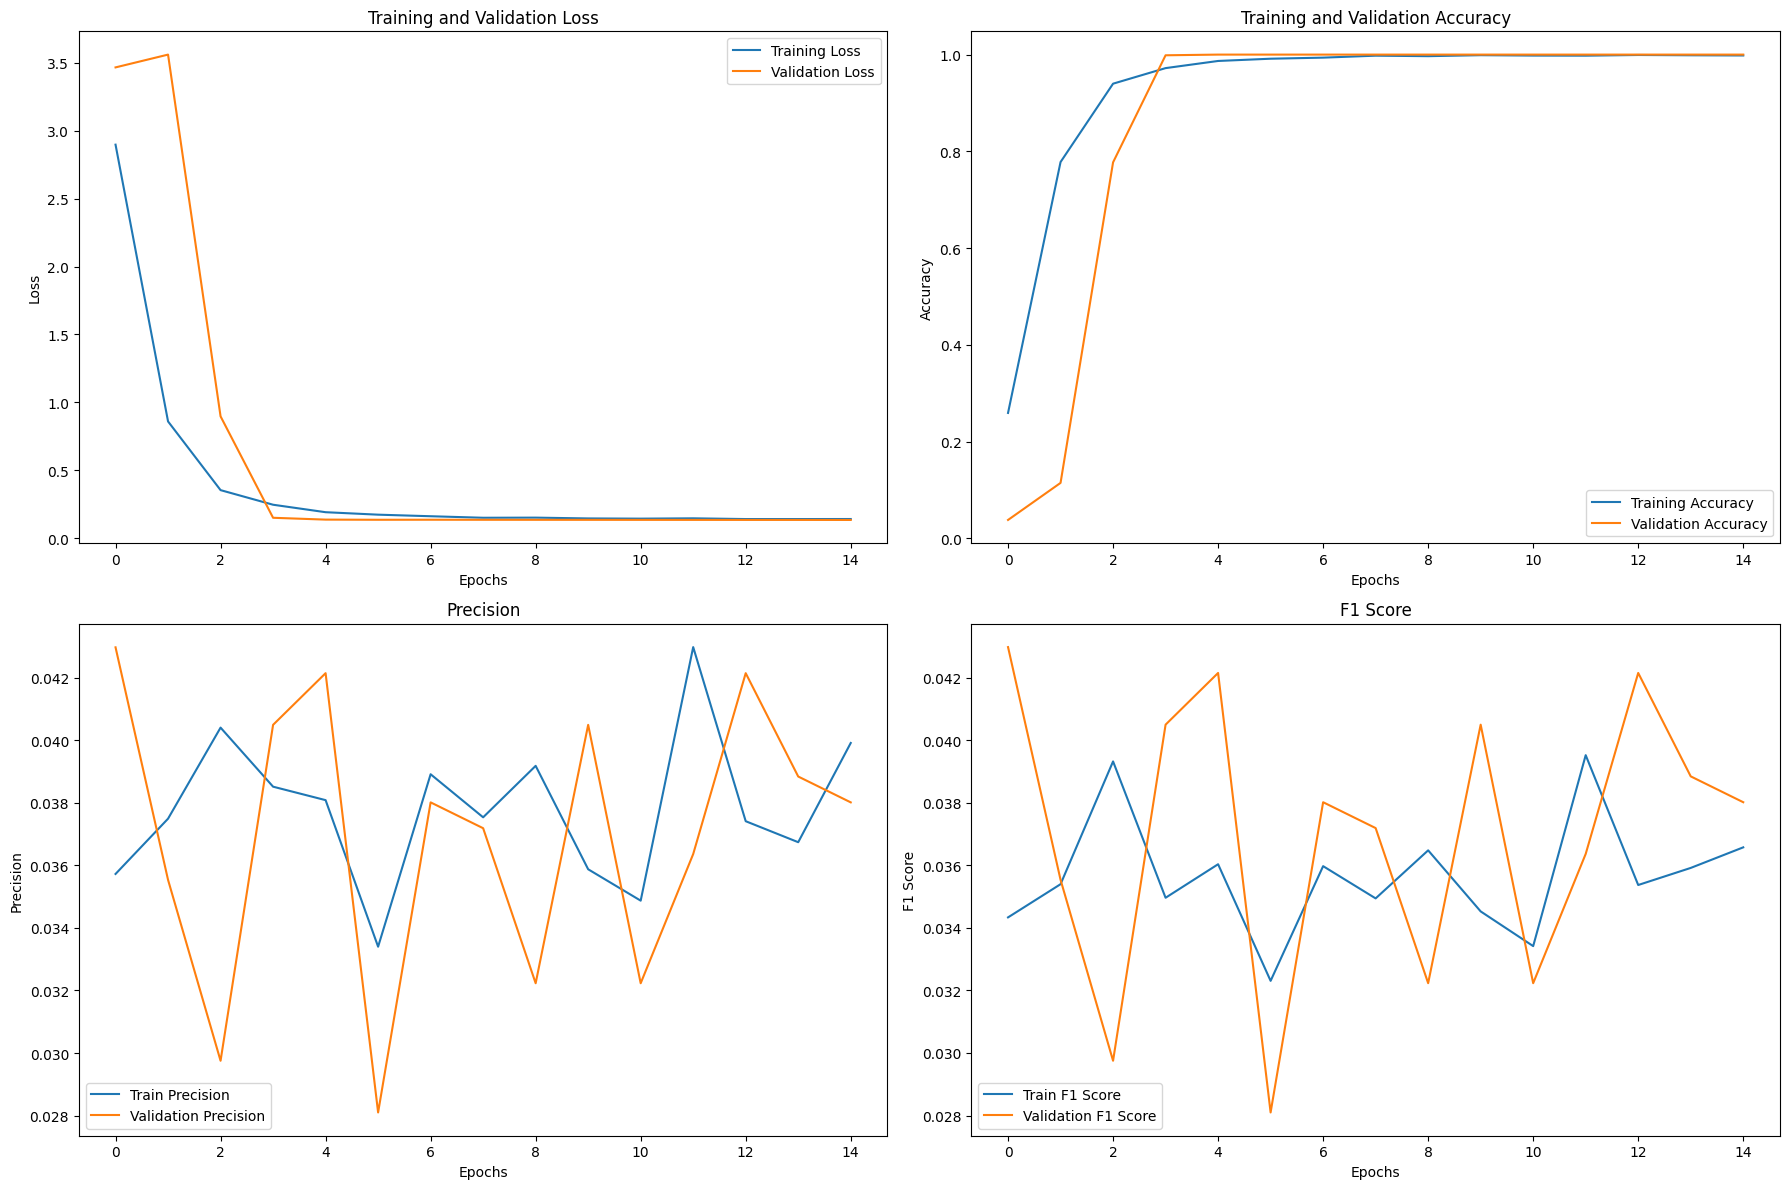

In [8]:
# Function to plot accuracy, loss, precision, recall, and F1-score
def plot_metrics(history):
    epochs = range(len(history.history['loss']))
    
    plt.figure(figsize=(18, 12))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Calculate Precision, Recall, and F1-Score
    train_precision = []
    train_recall = []
    train_f1 = []
    val_precision = []
    val_recall = []
    val_f1 = []

    for epoch in epochs:
        train_preds = np.argmax(model.predict(train_generator), axis=1)
        val_preds = np.argmax(model.predict(valid_generator), axis=1)

        train_labels = train_generator.classes
        val_labels = valid_generator.classes

        train_precision.append(precision_score(train_labels, train_preds, average='weighted'))
        train_recall.append(recall_score(train_labels, train_preds, average='weighted'))
        train_f1.append(f1_score(train_labels, train_preds, average='weighted'))

        val_precision.append(precision_score(val_labels, val_preds, average='weighted'))
        val_recall.append(recall_score(val_labels, val_preds, average='weighted'))
        val_f1.append(f1_score(val_labels, val_preds, average='weighted'))

    # Plot Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precision, label='Train Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision')

    # Plot F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_f1, label='Train F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score')

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)


# **Confusion Matrix**

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 0.1348
Test Accuracy: 100.00%
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Confusion Matrix:


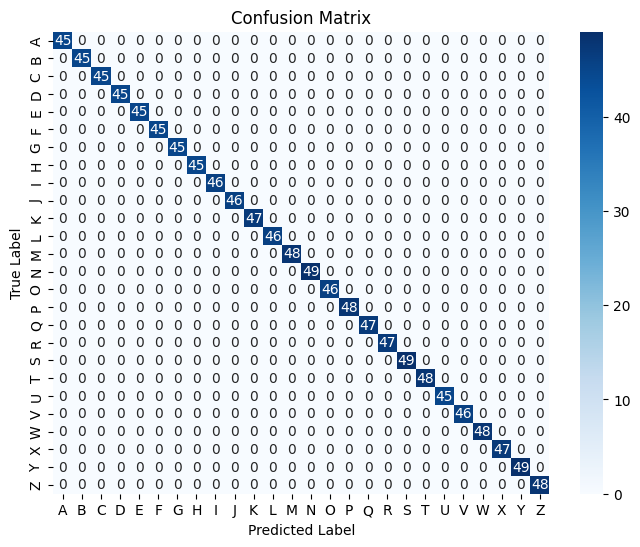

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes, labels=range(len(classes)))
cr = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **F1-score, Precision, Recall & Accuracy**

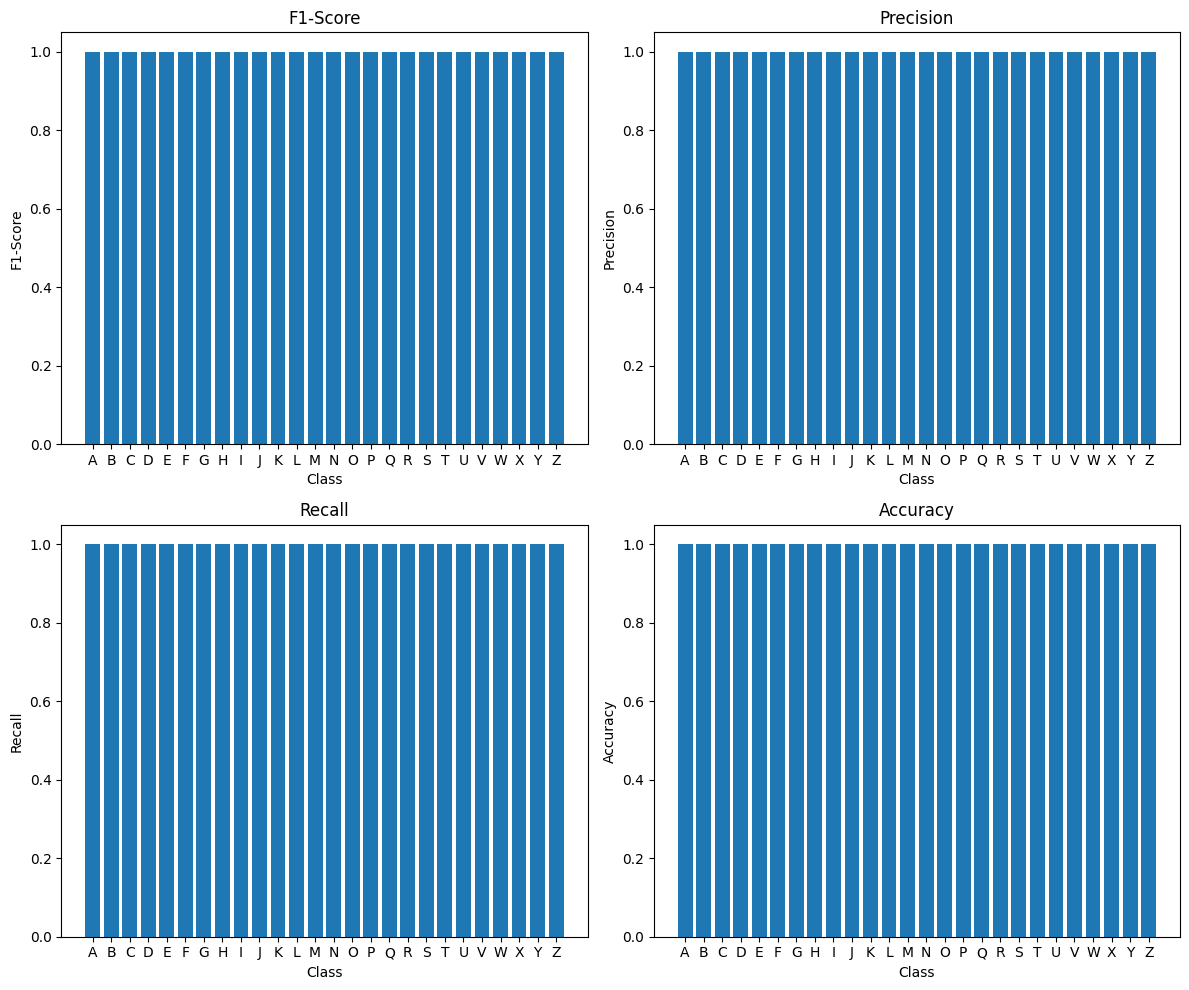


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        45
           B       1.00      1.00      1.00        45
           C       1.00      1.00      1.00        45
           D       1.00      1.00      1.00        45
           E       1.00      1.00      1.00        45
           F       1.00      1.00      1.00        45
           G       1.00      1.00      1.00        45
           H       1.00      1.00      1.00        45
           I       1.00      1.00      1.00        46
           J       1.00      1.00      1.00        46
           K       1.00      1.00      1.00        47
           L       1.00      1.00      1.00        46
           M       1.00      1.00      1.00        48
           N       1.00      1.00      1.00        49
           O       1.00      1.00      1.00        46
           P       1.00      1.00      1.00        48
           Q       1.00      1.00      1.00        47
   

In [10]:
# Extract metrics from classification report
f1_scores = [cr[class_name]['f1-score'] for class_name in classes]
precision = [cr[class_name]['precision'] for class_name in classes]
recall = [cr[class_name]['recall'] for class_name in classes]

# Calculate accuracy for each class
accuracy = []
for i in range(len(classes)):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    accuracy.append(tp / (tp + fp + fn))

# Create separate graphs for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(classes, f1_scores)
axs[0, 0].set_title('F1-Score')
axs[0, 0].set_xlabel('Class')
axs[0, 0].set_ylabel('F1-Score')

axs[0, 1].bar(classes, precision)
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Class')
axs[0, 1].set_ylabel('Precision')

axs[1, 0].bar(classes, recall)
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Class')
axs[1, 0].set_ylabel('Recall')

axs[1, 1].bar(classes, accuracy)
axs[1, 1].set_title('Accuracy')
axs[1, 1].set_xlabel('Class')
axs[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# **ROC Curve**

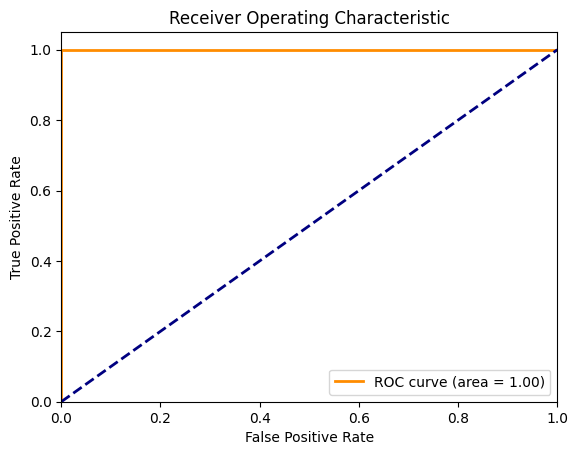

In [11]:
# ROC Curve and AUC
y_true_bin = label_binarize(y_true, classes=[i for i in range(len(classes))])
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **Getting Unique Images**

In [12]:
# Select one image per class from the test DataFrame
unique_classes = df_test['label'].unique()
one_image_per_class = df_test.groupby('label').first().reset_index()  # Get one image per class

# **Normaliztion**

In [13]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image


# **Taking Prediction For Image Visualization**

In [14]:
# List to store original and predicted labels
original_labels = []
predicted_labels = []

# Loop through each image and make predictions
for _, row in one_image_per_class.iterrows():
    image_path = row['path']
    original_label = row['label']

    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image, verbose=0)
    predicted_label_idx = np.argmax(prediction)
    predicted_label = classes[predicted_label_idx]

    # Store original and predicted labels
    original_labels.append(original_label)
    predicted_labels.append(predicted_label)


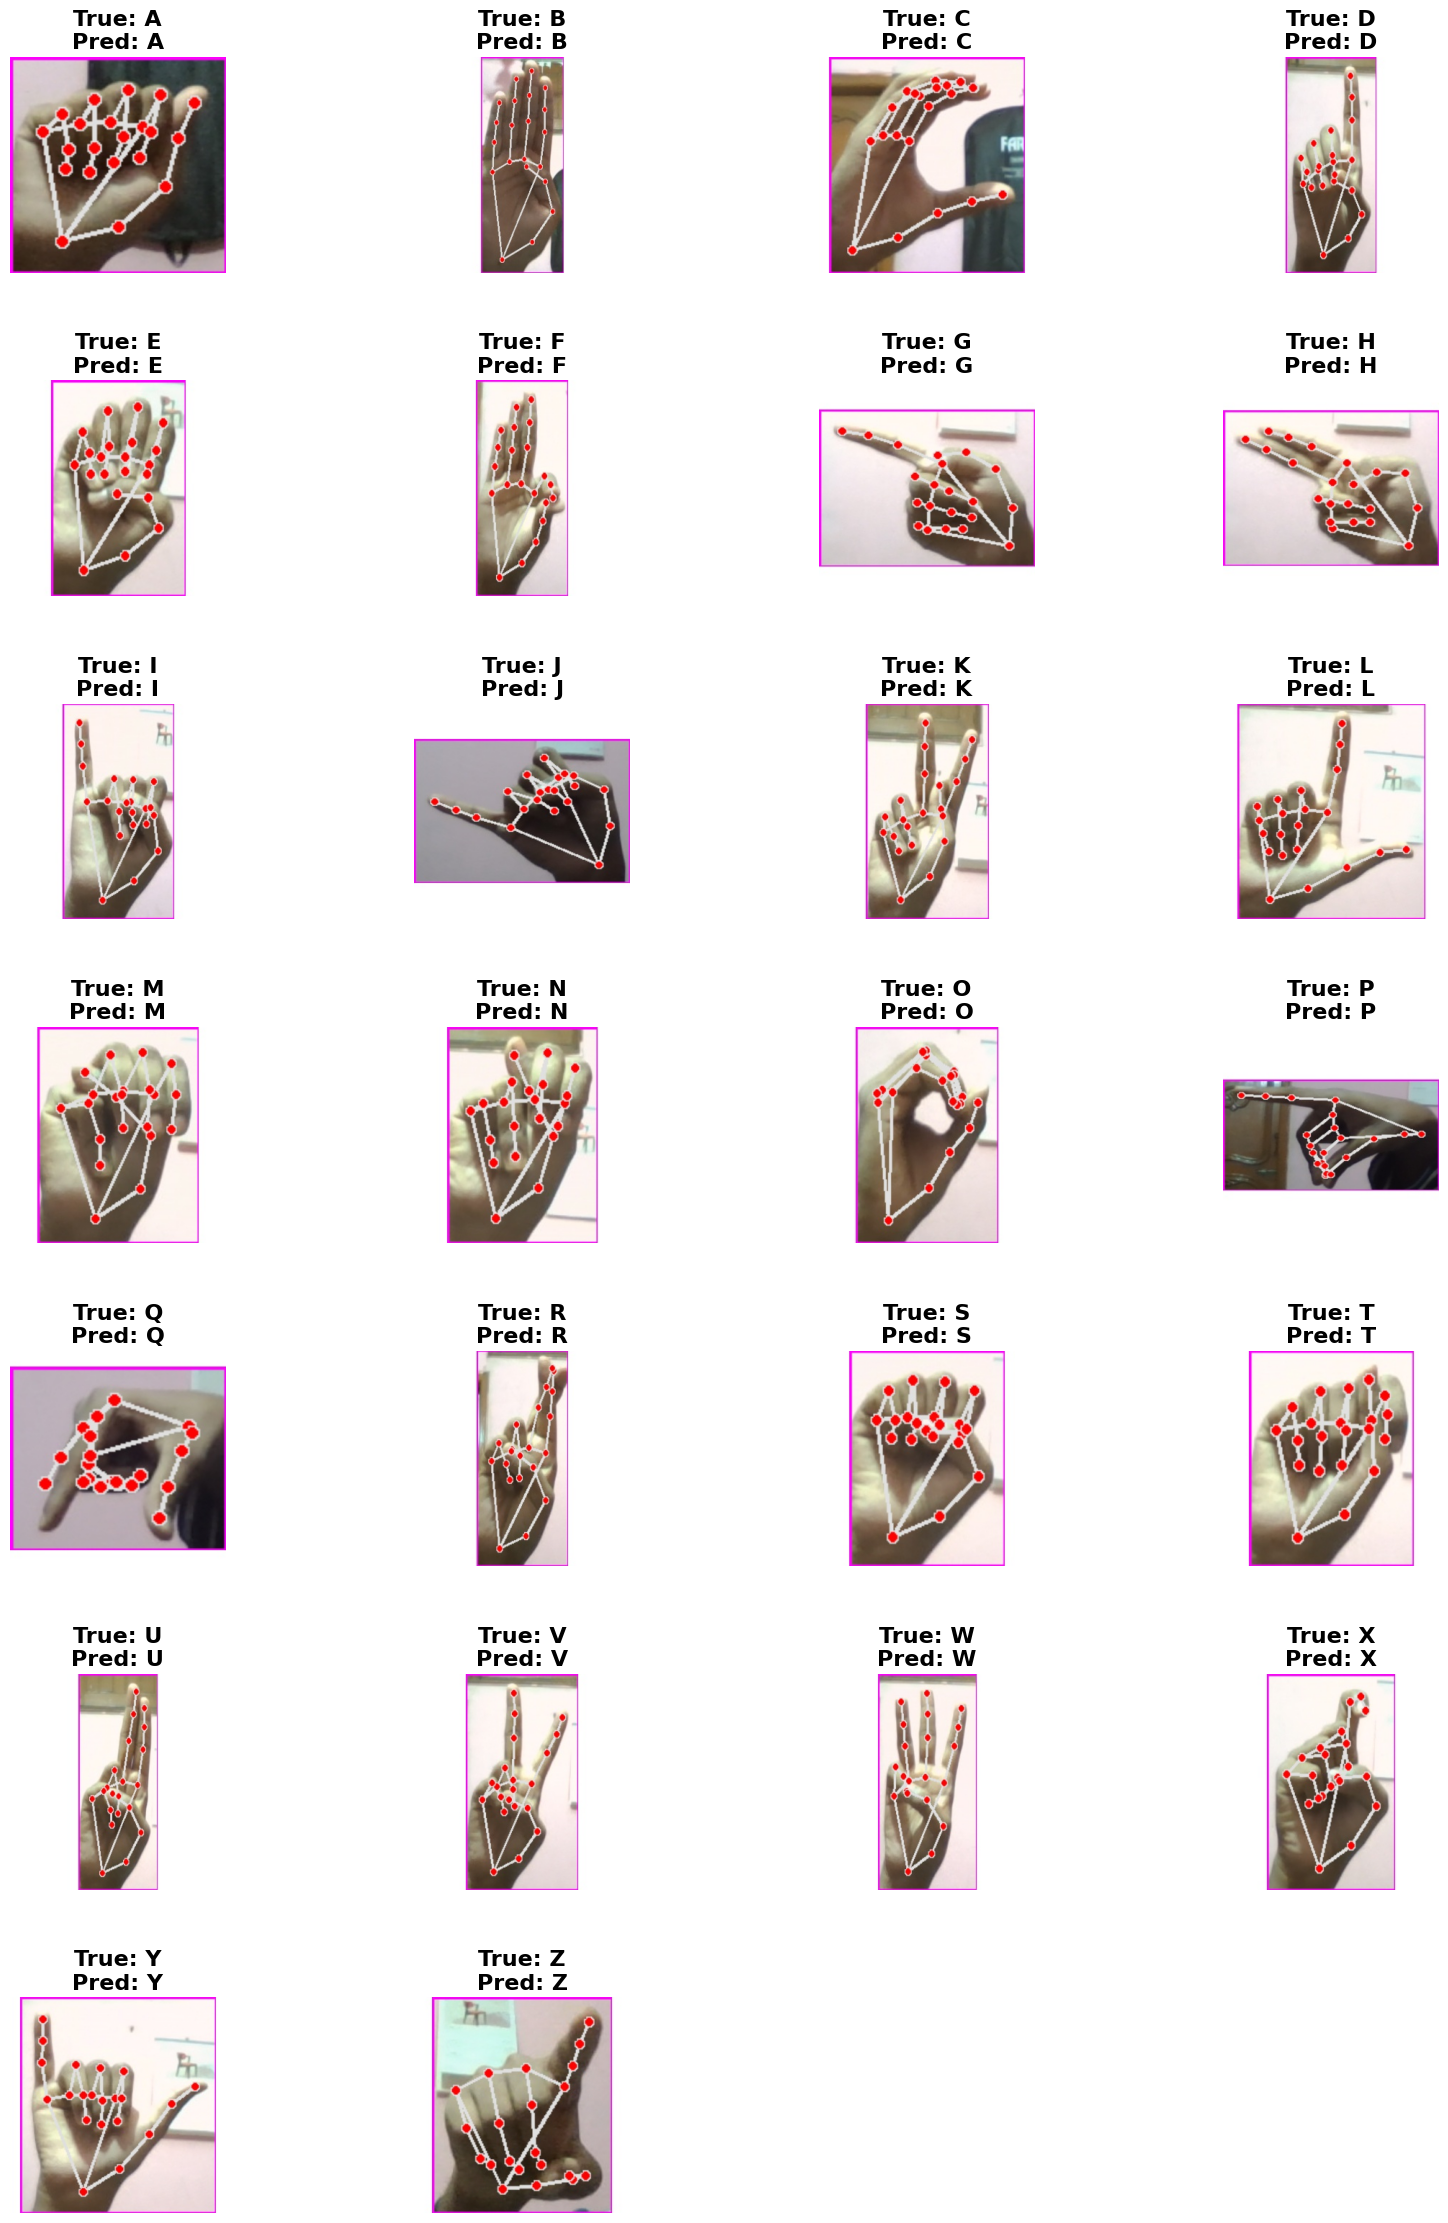

In [15]:
# Plot images with true and predicted labels
plt.figure(figsize=(20, 28))  # Adjust figure size for better spacing

# Define the number of images per row and total rows
images_per_row = 4
total_rows = (len(one_image_per_class) + images_per_row - 1) // images_per_row  # Calculate rows dynamically

for idx, (image_path, true_label, pred_label) in enumerate(zip(one_image_per_class['path'], original_labels, predicted_labels)):
    plt.subplot(total_rows, images_per_row, idx + 1)
    img = plt.imread(image_path)
    plt.imshow(img)
    
    # Make labels prominent
    plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=16, fontweight='bold')
    
    # Remove axis for cleaner look
    plt.axis('off')

# Ensure spacing is handled properly between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
